# Init

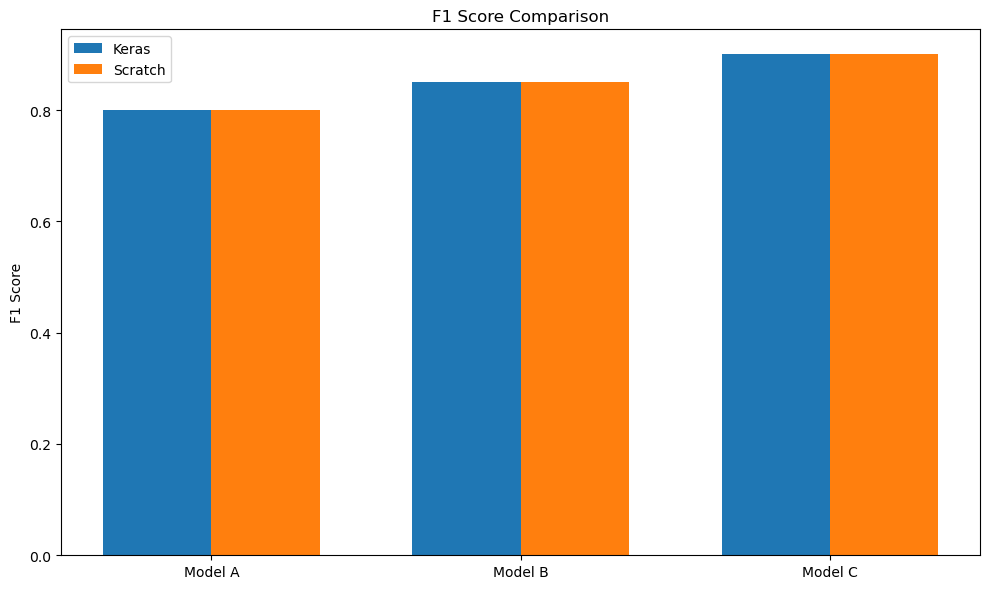

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


from layers.embedding import EmbeddingLayer
from layers.rnn.bidirectionalRNN import BidirectionalRNN
from layers.rnn.unidirectionalRNN import UnidirectionalRNN
from layers.dropout import DropoutLayer
from layers.dense import DenseLayer

from model_scratch.model import Model
from model_scratch.rnn import RNN
from utils.evaluate import evaluate_model
from utils.visualize import visualize_loss, visualize_f1, visualize_train_val_loss

from sklearn.metrics import f1_score
import random

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/valid.csv')
train['label'] = train['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
test['label'] = test['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
valid['label'] = valid['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)

# Set random seed for reproducibility
seed = 42
random.seed(seed)                         # python random
np.random.seed(seed)                      # numpy
tf.random.set_seed(seed)   

In [3]:
tokenizer = Tokenizer(oov_token="<UNK>")  # Reserve a token for unknown words
tokenizer.fit_on_texts(train['text'].values) 
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2796


In [4]:
embedding_dim = 50 # Dimension of the embedding layer
max_length = 60  # Maximum length of input sequences

train_sequences = tokenizer.texts_to_sequences(train['text'].values)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
valid_sequences = tokenizer.texts_to_sequences(valid['text'].values)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = tokenizer.texts_to_sequences(test['text'].values)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)

95th Percentile Length: 54.0
98th Percentile Length: 59.0


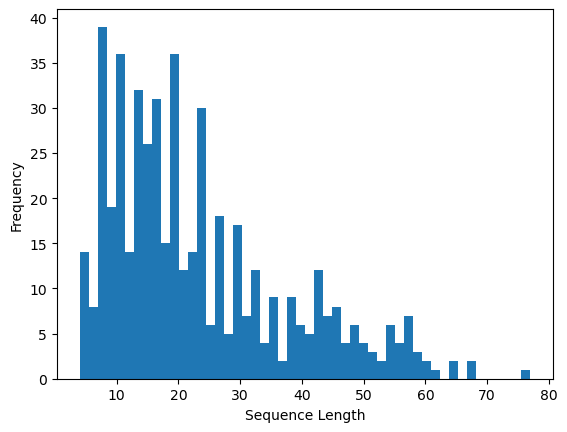

In [5]:
import matplotlib.pyplot as plt
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train['text'].values)]
percentile_95 = np.percentile(lengths, 95)
percentile_98 = np.percentile(lengths, 98)
print(f"95th Percentile Length: {percentile_95}")
print(f"98th Percentile Length: {percentile_98}")
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

In [6]:
print(f"Train padded shape: {train_padded.shape}")
print(f"Valid padded shape: {valid_padded.shape}")
print(f"Test padded shape: {test_padded.shape}")

Train padded shape: (500, 60)
Valid padded shape: (100, 60)
Test padded shape: (400, 60)


In [7]:
def get_weights_per_layer(model, verbose=True):
    all_weights = []
    for layer in model.layers:
        if verbose:
            print(f"Layer: {layer.name}") 
        weights = layer.get_weights()
        all_weights.append(weights)
        if verbose:
            for i, w in enumerate(weights):
                print(f"  Weight {i}: shape {w.shape}")
    return all_weights

# Pengaruh Jumlah Layer

In [8]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## 1 layer RNN

In [9]:
# Build the model
layer1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1, verbose=False)


# Evaluate the model
score_1_layer = evaluate_model(layer1, test_padded, test['label'])
scores.append(score_1_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Macro F1 Score: 0.3445


In [10]:
layer1Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1Scratch.load_weights(all_weights)

# Evaluate the model
score_1_layer_scratch = evaluate_model(layer1Scratch, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch)

Macro F1 Score: 0.3445


## 2 Layer RNN

In [11]:
# Build the model
layer2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer2.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer2, verbose=False)

# Evaluate the model
score_2_layer = evaluate_model(layer2, test_padded, test['label'])
scores.append(score_2_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Macro F1 Score: 0.3745


In [12]:
layer2Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer2Scratch.load_weights(all_weights)

# Evaluate the model
score_2_layer_scratch = evaluate_model(layer2Scratch, test_padded, test['label'])
scores_scratch.append(score_2_layer_scratch)

Macro F1 Score: 0.3745


## 3 Layer RNN


In [13]:
# Build the model
layer3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer3.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer3, verbose=False)

# Evaluate the model
score_3_layer = evaluate_model(layer3, test_padded, test['label'])
scores.append(score_3_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Macro F1 Score: 0.3668


In [14]:
layer3Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer3Scratch.load_weights(all_weights)

# Evaluate the model
score_3_layer_scratch = evaluate_model(layer3Scratch, test_padded, test['label'])
scores_scratch.append(score_3_layer_scratch)

Macro F1 Score: 0.3668


Score for Layer 1:
  F1 Score: 0.34451120378878913
Score for Layer 2:
  F1 Score: 0.37446996920095993
Score for Layer 3:
  F1 Score: 0.36682066007700226
Score for Layer 1 Scratch:
  F1 Score: 0.34451120378878913
Score for Layer 2 Scratch:
  F1 Score: 0.37446996920095993
Score for Layer 3 Scratch:
  F1 Score: 0.36682066007700226
Train Loss for Layer 1: [1.0911662578582764, 0.8779237270355225, 0.5865400433540344, 0.4214332401752472, 0.3684505224227905, 0.3924495577812195, 0.4746731221675873, 0.3193356990814209, 0.2256661355495453, 0.195949986577034]
Train Loss for Layer 2: [1.0877987146377563, 1.0024057626724243, 0.7243351340293884, 0.5542219877243042, 0.3274913430213928, 0.20090371370315552, 0.14435943961143494, 0.11187814921140671, 0.0911727175116539, 0.07725049555301666]
Train Loss for Layer 3: [1.116463541984558, 1.0264276266098022, 0.9234990477561951, 0.8088780641555786, 0.6037775874137878, 0.4032873511314392, 0.28314390778541565, 0.21280792355537415, 0.17913182079792023, 0.16176226

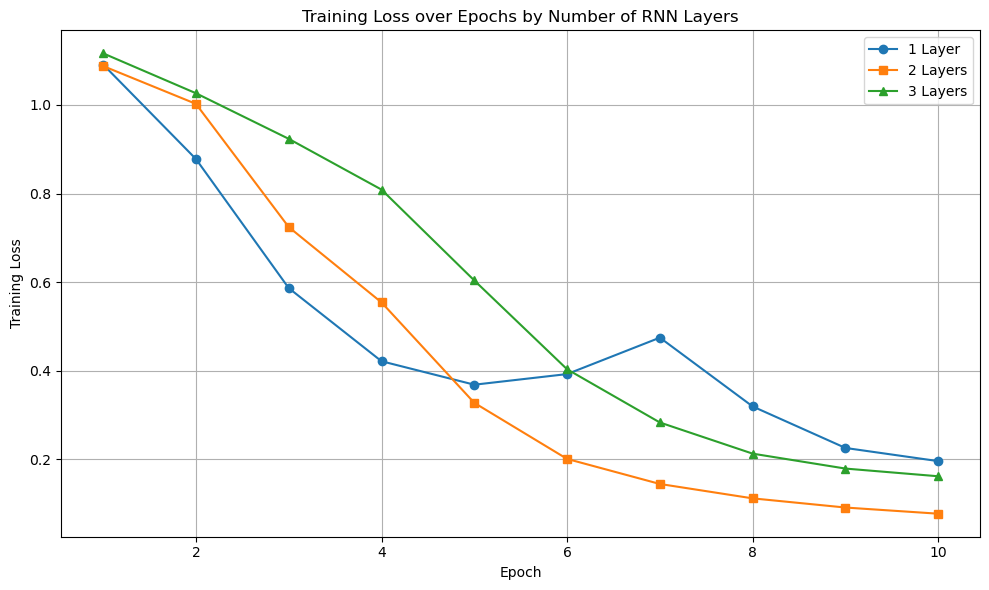

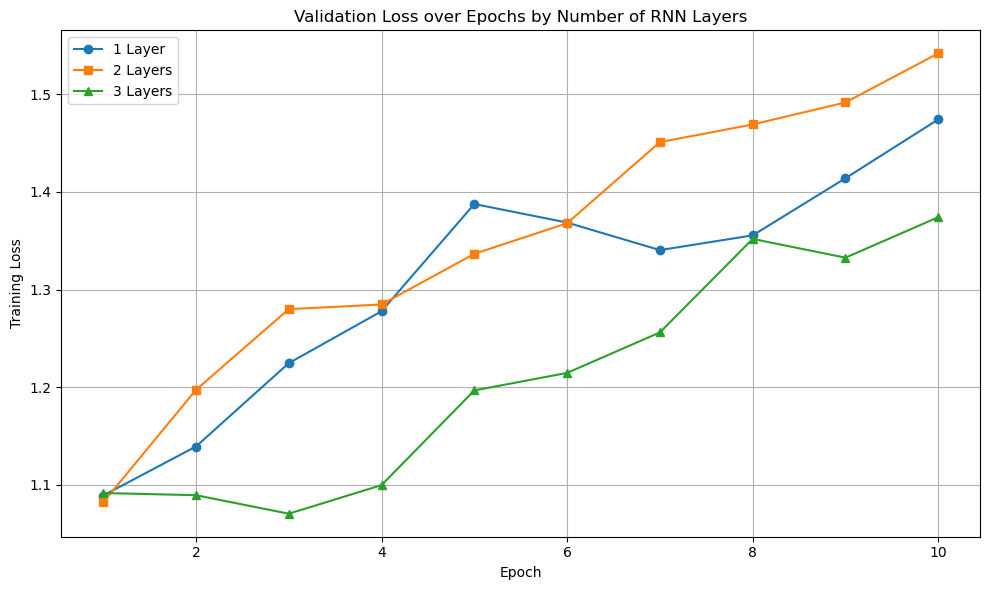

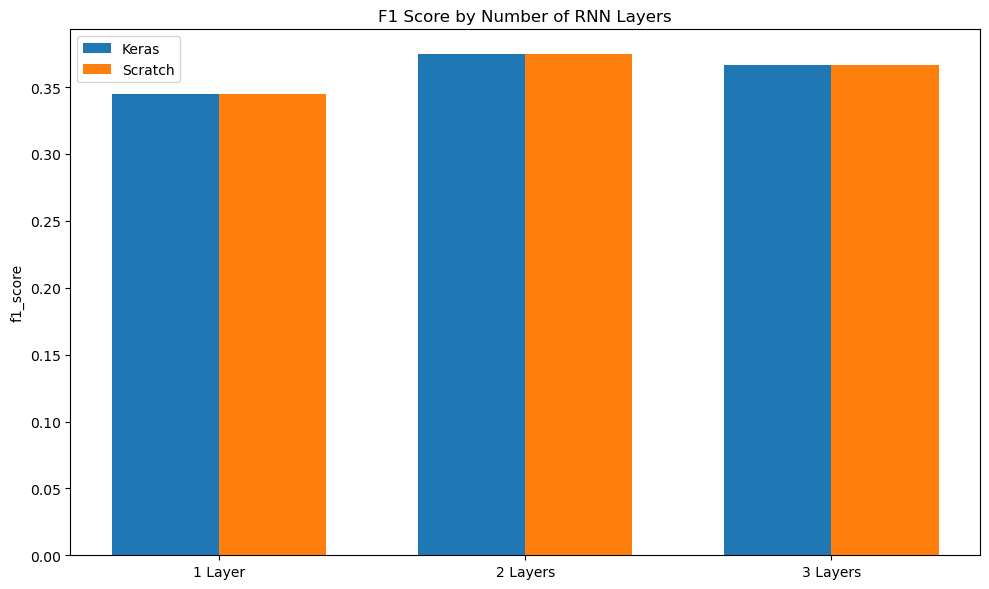

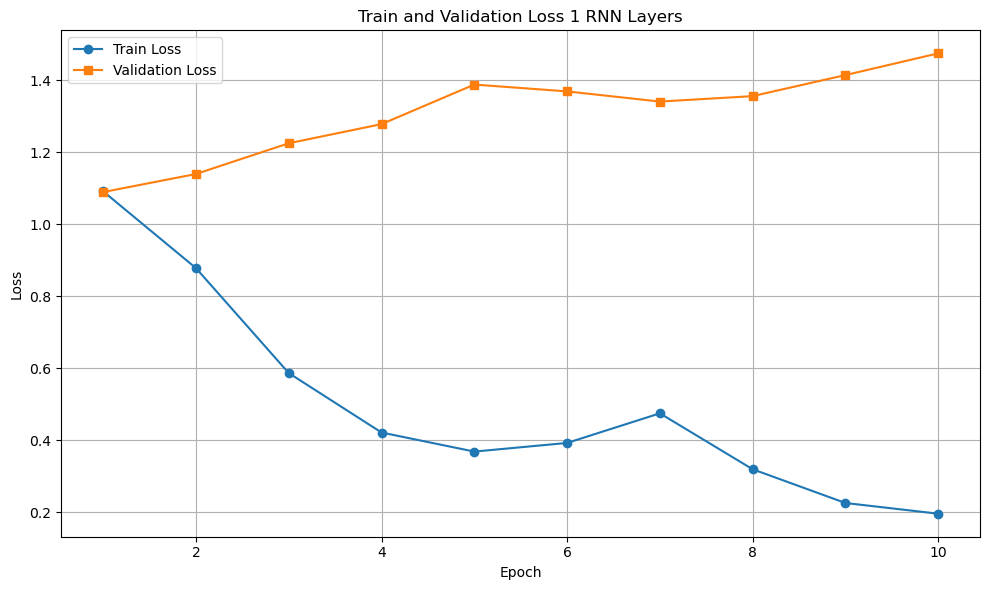

In [ ]:
for i, score in enumerate(scores):
    print(f"Score for Layer {i+1}:")
    print(f"  F1 Score: {score}")

for i, score in enumerate(scores_scratch):
    print(f"Score for Layer {i+1} Scratch:")
    print(f"  F1 Score: {score}")

for i, loss in enumerate(train_loss):
    print(f"Train Loss for Layer {i+1}: {loss}")

for i, loss in enumerate(val_loss):
    print(f"Validation Loss for Layer {i+1}: {loss}")

visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['1 Layer', '2 Layers', '3 Layers'], 'Training Loss over Epochs by Number of RNN Layers')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['1 Layer', '2 Layers', '3 Layers'], 'Validation Loss over Epochs by Number of RNN Layers')
visualize_f1(scores, scores_scratch, ['1 Layer', '2 Layers', '3 Layers'], title='F1 Score by Number of RNN Layers')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss 1 RNN Layers')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss 2 RNN Layers')
visualize_train_val_loss(train_loss=train_loss[2], val_loss=val_loss[2], epochs=list(range(1, len(train_loss[2])+1)), title='Train and Validation Loss 3 RNN Layers')

# Pengaruh Banyak Cell RNN per Layer

In [16]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## 8 Cell

In [17]:
# Build the model
cell8 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell8.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell8, verbose=False)


# Evaluate the model
score_8_cell = evaluate_model(cell8, test_padded, test['label'])
scores.append(score_8_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Macro F1 Score: 0.5350


In [18]:
cell8Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

cell8Scratch.load_weights(all_weights)

# Evaluate the model
score_8_cell_scratch = evaluate_model(cell8Scratch, test_padded, test['label'])
scores_scratch.append(score_8_cell_scratch)

Macro F1 Score: 0.5350


## 16 Cell

In [19]:
# Build the model
cell16 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=16, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell16.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell16, verbose=False)


# Evaluate the model
score_16_cell = evaluate_model(cell16, test_padded, test['label'])
scores.append(score_16_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Macro F1 Score: 0.4543


In [20]:
cell16Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(16, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 16, activation='softmax', init_method='zeros')
], 32)

cell16Scratch.load_weights(all_weights)

# Evaluate the model
score_16_cell_scratch = evaluate_model(cell16Scratch, test_padded, test['label'])
scores_scratch.append(score_16_cell_scratch)

Macro F1 Score: 0.4543


## 24 Cell

In [21]:
# Build the model
cell24 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=24, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell24.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell24.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell24, verbose=False)


# Evaluate the model
score_24_cell = evaluate_model(cell24, test_padded, test['label'])
scores.append(score_24_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Macro F1 Score: 0.2760


In [22]:
cell24Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(24, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 24, activation='softmax', init_method='zeros')
], 32)

cell24Scratch.load_weights(all_weights)

# Evaluate the model
score_24_cell_scratch = evaluate_model(cell24Scratch, test_padded, test['label'])
scores_scratch.append(score_24_cell_scratch)

Macro F1 Score: 0.2760


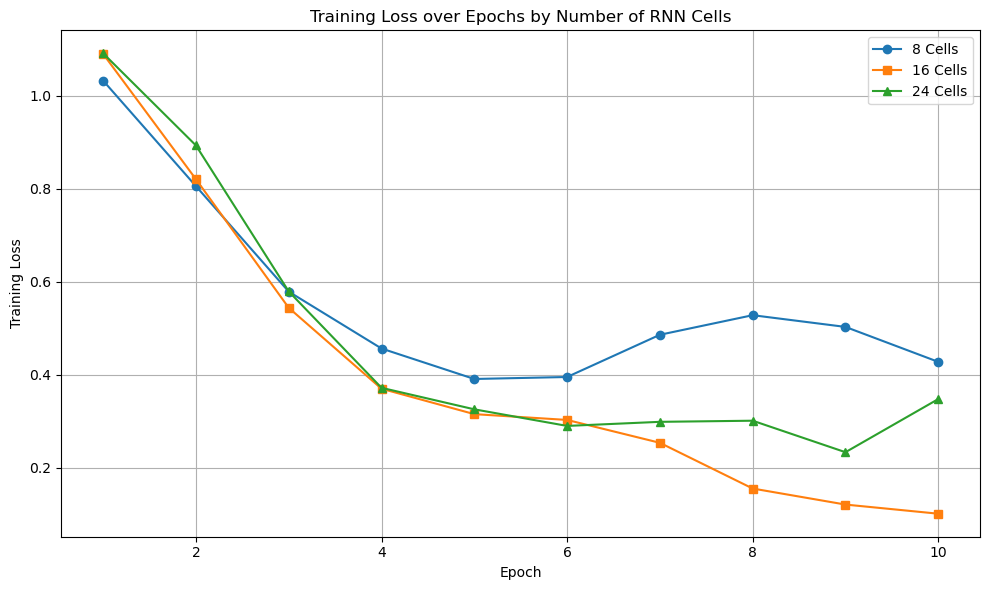

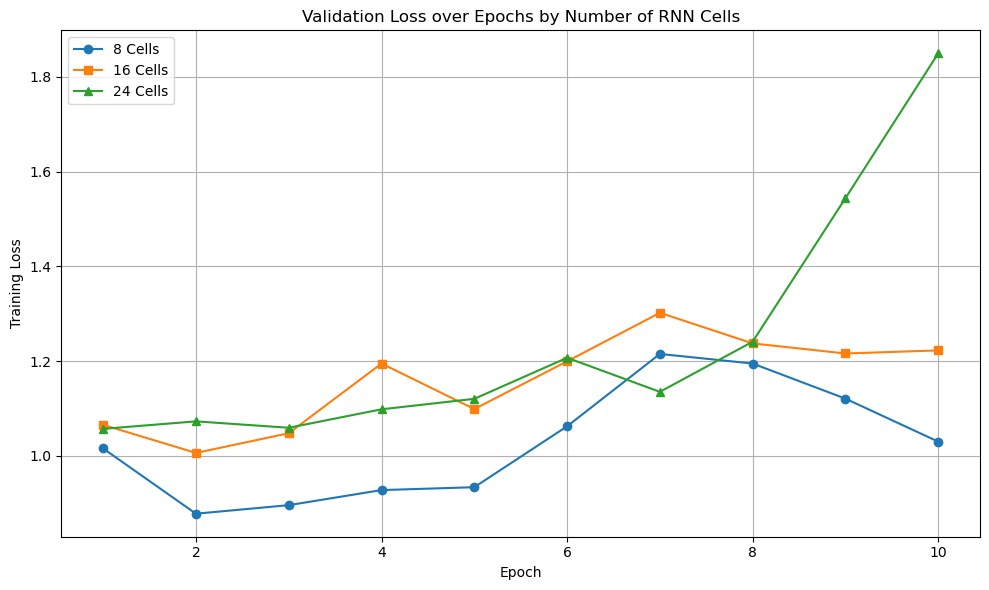

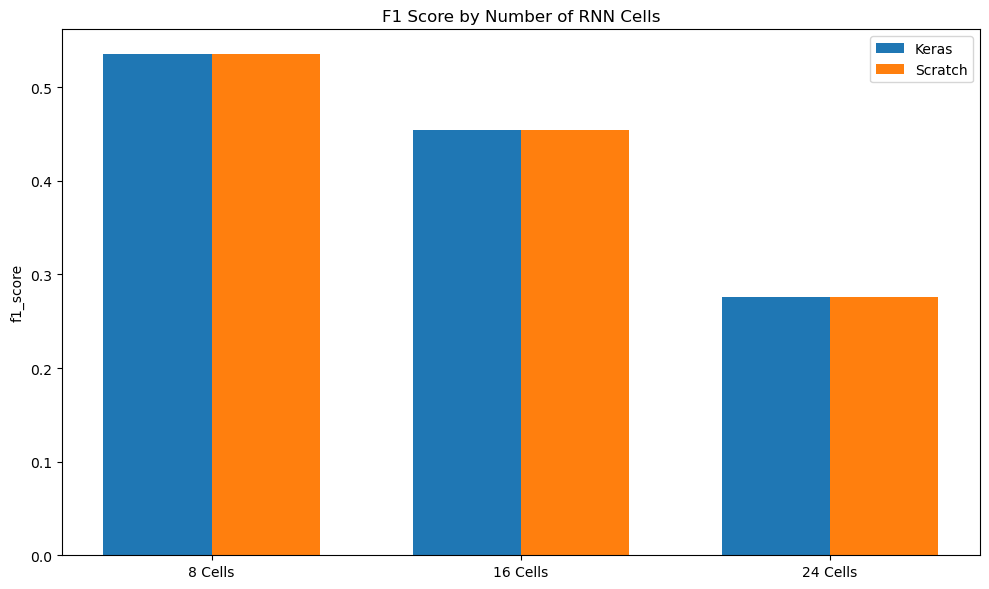

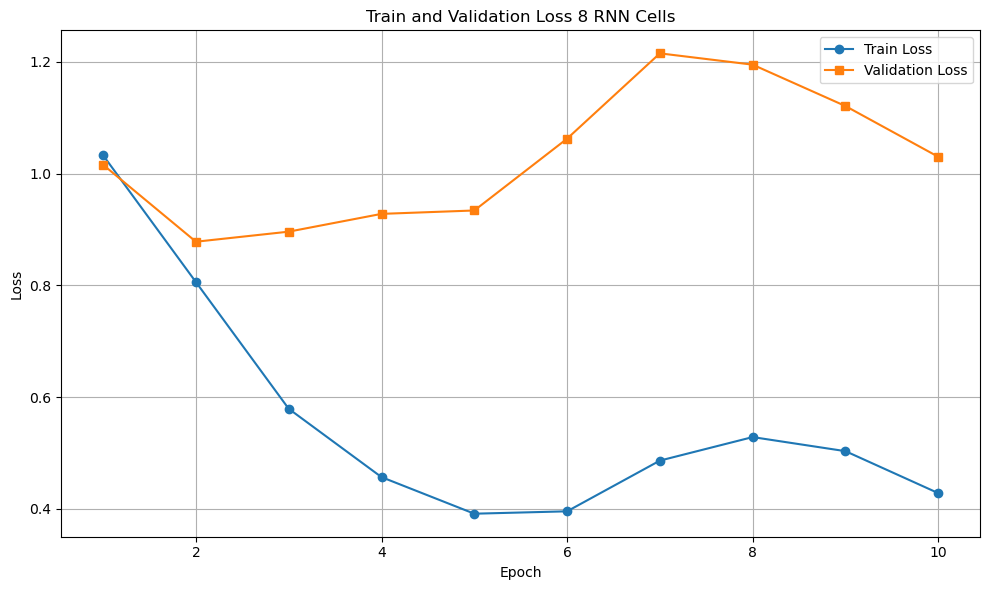

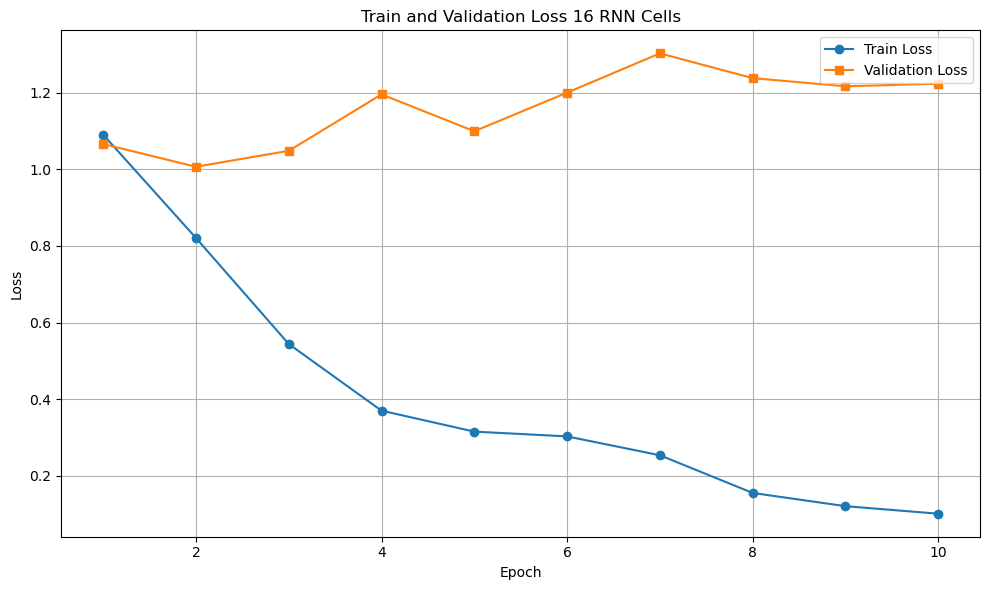

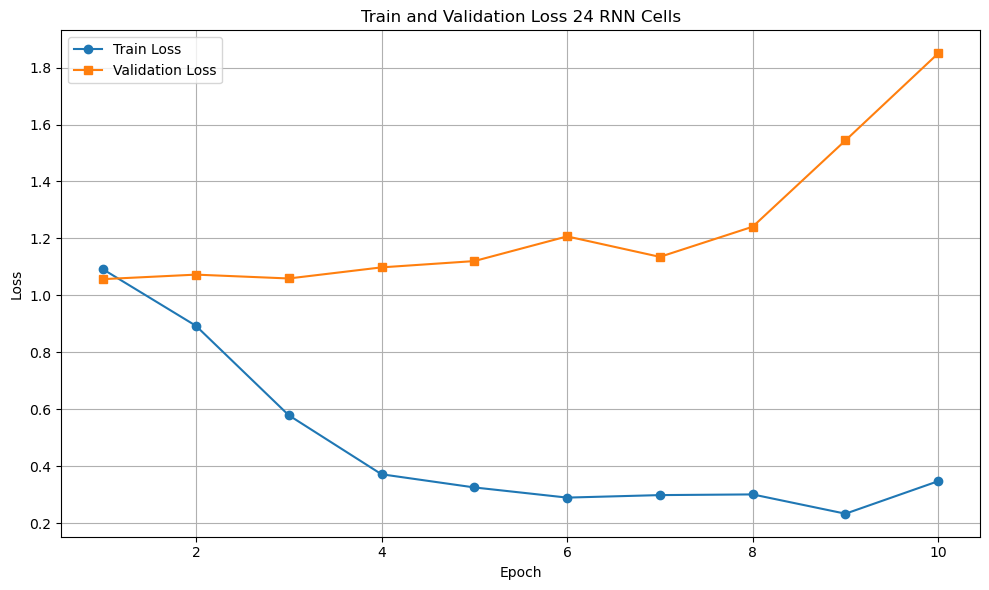

In [23]:
visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['8 Cells', '16 Cells', '24 Cells'], 'Training Loss over Epochs by Number of RNN Cells')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['8 Cells', '16 Cells', '24 Cells'], 'Validation Loss over Epochs by Number of RNN Cells')
visualize_f1(scores, scores_scratch, ['8 Cells', '16 Cells', '24 Cells'], title='F1 Score by Number of RNN Cells')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss 8 RNN Cells')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss 16 RNN Cells')
visualize_train_val_loss(train_loss=train_loss[2], val_loss=val_loss[2], epochs=list(range(1, len(train_loss[2])+1)), title='Train and Validation Loss 24 RNN Cells')

# Pengaruh jenis layer RNN berdasarkan arah

In [8]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## Unidirectional

In [9]:
# Build the model
layer1Uni = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1Uni.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1Uni.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1Uni, verbose=False)


# Evaluate the model
score_1_layer_Uni = evaluate_model(layer1Uni, test_padded, test['label'])
scores.append(score_1_layer_Uni)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Macro F1 Score: 0.3445


In [10]:
layer1ScratchUni = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1ScratchUni.load_weights(all_weights)

# Evaluate the model
score_1_layer_scratch_Uni = evaluate_model(layer1ScratchUni, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch_Uni)

Macro F1 Score: 0.3445


## Bidirectional

In [9]:
# Build the model
layer1Bi = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(SimpleRNN(units=2, activation='tanh', return_sequences=False)),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1Bi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1Bi.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)


train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1Bi, verbose=False)

# Evaluate the model
score_1_layer_Bi = evaluate_model(layer1Bi, test_padded, test['label'])
scores.append(score_1_layer_Bi)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Macro F1 Score: 0.4207


In [10]:
layer1Scratch_Bi = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    BidirectionalRNN(2, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1Scratch_Bi.load_weights(all_weights)
# print(layer1Scratch_Bi.predict(train_padded[:1]).data.numpy())

# Evaluate the model
score_1_layer_scratch_Bi = evaluate_model(layer1Scratch_Bi, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch_Bi)

Macro F1 Score: 0.4207


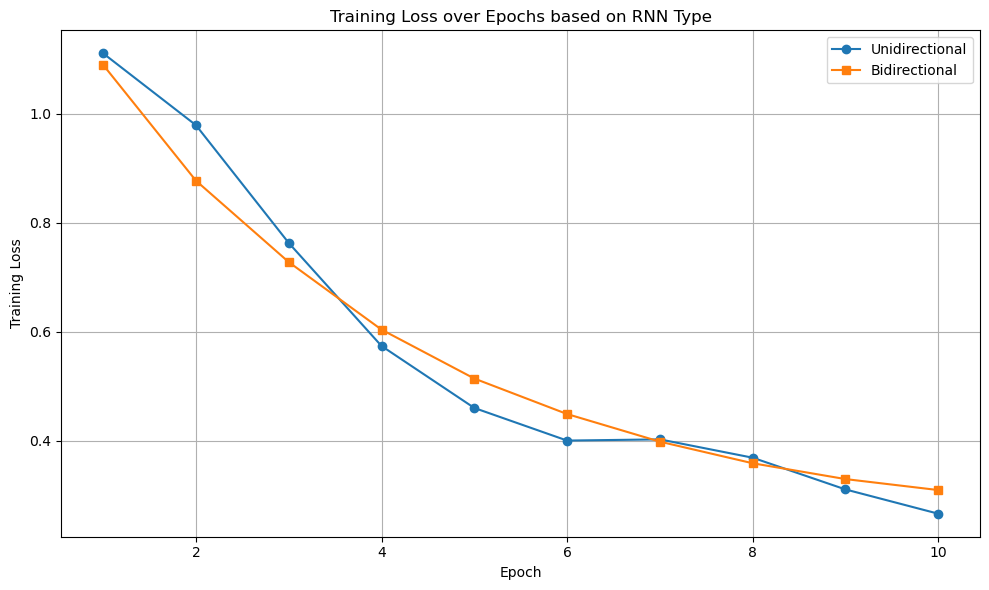

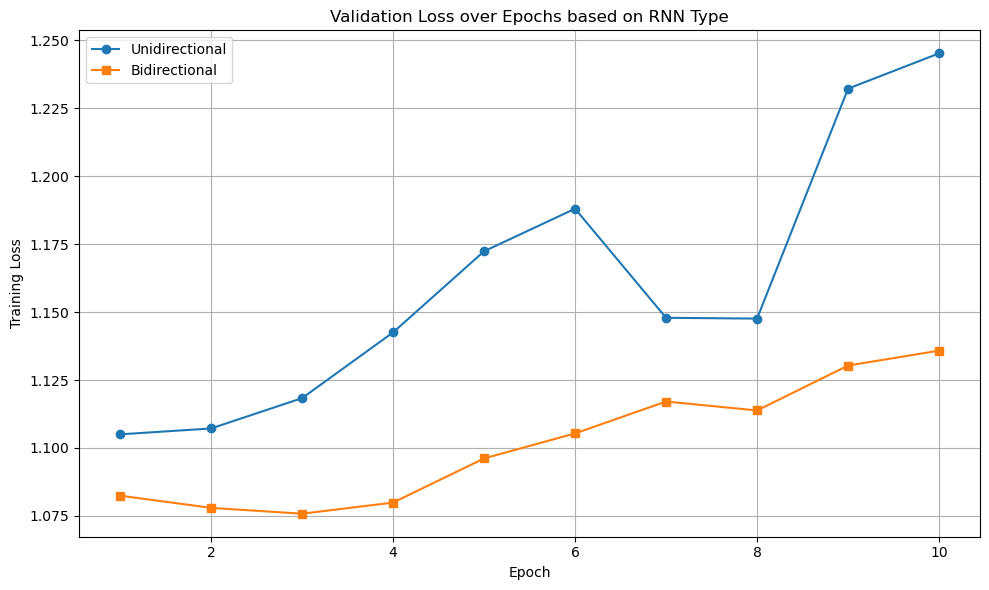

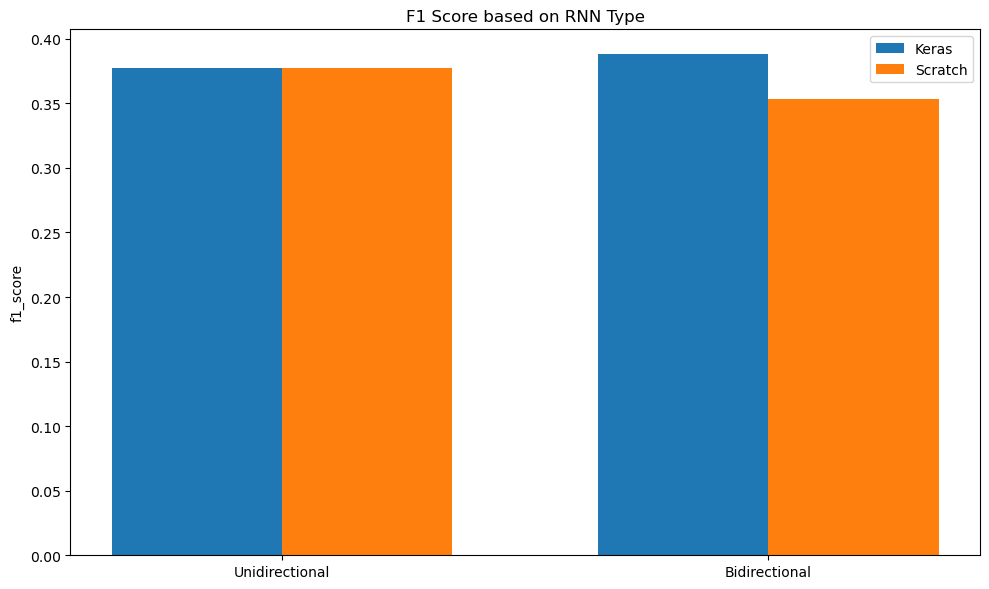

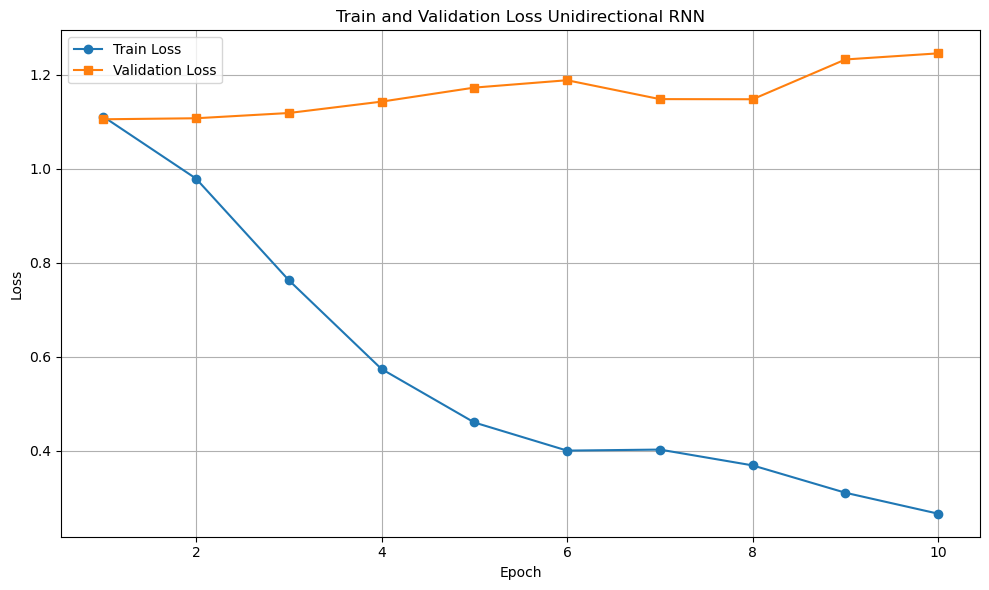

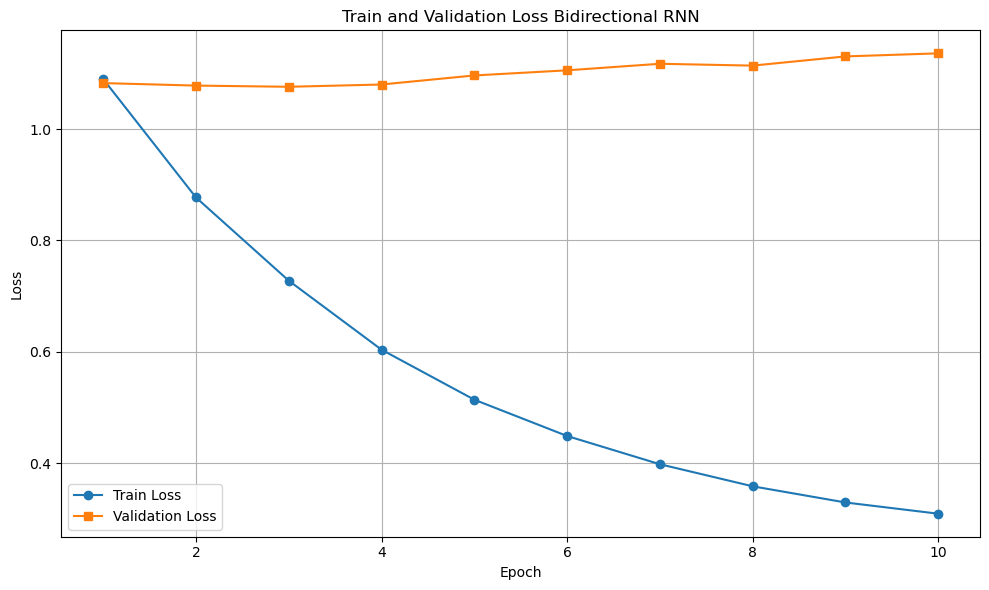

In [ ]:
visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['Unidirectional', 'Bidirectional'], 'Training Loss over Epochs based on RNN Type')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['Unidirectional', 'Bidirectional'], 'Validation Loss over Epochs based on RNN Type')
visualize_f1(scores, scores_scratch, ['Unidirectional', 'Bidirectional'], title='F1 Score based on RNN Type')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss Unidirectional RNN')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss Bidirectional RNN')

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense

# Redefine model using functional API to allow access to .input and .output
print(train_padded.shape)
input_layer = Input(shape=(train_padded.shape[1],))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
rnn = Bidirectional(SimpleRNN(units=8, activation='tanh', return_sequences=False))(embedding)
# rnn2 = SimpleRNN(units=8, activation='tanh', return_sequences=False)(rnn)
output = Dense(3, activation='softmax')(rnn)

# Define the full model
model = Model(inputs=input_layer, outputs=output)

# Compile and fit as usual
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_padded, train['label'].values,
          validation_data=(valid_padded, valid['label'].values),
          epochs=10, batch_size=32, verbose=0)

# Now you can get intermediate outputs
intermediate_model = Model(inputs=model.input, outputs=[embedding, rnn, output])
sample_input = train_padded[:1]
outputs = intermediate_model.predict(sample_input)

for i, layer_output in enumerate(outputs):
    print(f"\nLayer {i} Output:")
    print(layer_output)


(500, 60)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

Layer 0 Output:
[[[-0.05100861  0.01937658  0.01154684 ... -0.07239766 -0.00241891
   -0.01382664]
  [-0.05078064 -0.0098821  -0.0561595  ... -0.00719147 -0.00611131
    0.02524322]
  [ 0.0306783  -0.03957502  0.01116489 ...  0.04056357  0.05723416
    0.00290531]
  ...
  [ 0.14696313 -0.15954673 -0.10120119 ... -0.06234939  0.19408464
    0.06579204]
  [ 0.14696313 -0.15954673 -0.10120119 ... -0.06234939  0.19408464
    0.06579204]
  [ 0.14696313 -0.15954673 -0.10120119 ... -0.06234939  0.19408464
    0.06579204]]]

Layer 1 Output:
[[ 0.06293731 -0.69987583  0.4237317  -0.63130945 -0.3448511   0.20554295
   0.06290092 -0.08885026  0.6554653  -0.30481282 -0.6201311   0.6249425
  -0.0560303   0.67371315 -0.5625181   0.53460103]]

Layer 2 Output:
[[0.9080862  0.06531732 0.02659654]]


In [30]:
from utils.autodiff import Value
print(model.layers[3])  # Embedding layer weights
embeddinglayer = EmbeddingLayer(vocab_size, embedding_dim).load_weights(model.layers[1].get_weights())
output = embeddinglayer(train_padded[:1])
# print("Embedding Layer Output:")
# print(output.data.numpy())


forward = UnidirectionalRNN(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights()[:3])
output_f = forward(output.data)
# print("Unidirectional RNN Forward Output:")
# print(output_f.data.numpy())

back = UnidirectionalRNN(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights()[3:6])
output_b = back(output.data.flip(dims=[1]))
# print("Unidirectional RNN Output:")
# print(output_b.data.flip(dims=[1]))
output_b = Value(output_b.data.flip(dims=[1]))
print(Value.cat([output_f, output_b], dim=2).data.numpy())

bidirectional = BidirectionalRNN(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights())
output_bi = bidirectional(output.data)
print("Bidirectional RNN Output:")
print(output_bi.data.numpy())

# model_scratch = RNN([
#     EmbeddingLayer(vocab_size, embedding_dim),
#     UnidirectionalRNN(8, return_sequences=False, activation='tanh', go_backwards=True),
#     DenseLayer(3, 8, activation='softmax', init_method='zeros')
# ], 32)

<Dense name=dense_4, built=True>
[[[-0.02371382  0.0993406   0.01177543  0.05728402 -0.03343872
   -0.07871473 -0.11978711  0.10354286  0.6554651  -0.3048128
   -0.6201311   0.6249426  -0.05603031  0.673713   -0.5625181
    0.53460103]
  [ 0.10662295 -0.01051939 -0.11795913 -0.07928384  0.03378058
   -0.15257905  0.12240703  0.12919122  0.7436049  -0.40359956
   -0.03422562  0.19799206  0.5148305   0.5748876  -0.57967204
    0.5795289 ]
  [-0.06463286  0.00943858  0.09088013 -0.08212926 -0.2744583
   -0.15332235 -0.01977966  0.17187306  0.66404223 -0.7023273
   -0.59366786 -0.26443702  0.49545658  0.5276625  -0.21128011
    0.37422636]
  [ 0.06943028 -0.03704911  0.0717516  -0.18328077 -0.16898157
   -0.12926692  0.25617328  0.19753361  0.61726207 -0.53469163
   -0.7118945   0.26928082  0.12150168  0.6784581   0.06794839
    0.55708706]
  [-0.1463323  -0.02156446  0.2635848  -0.09145466 -0.35273886
   -0.02470305  0.26809016  0.23432502  0.6612034  -0.19842722
   -0.470335    0.5140921

In [11]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Bidirectional

# Example: assume train_padded and other vars are already defined
# train_padded.shape → (num_samples, sequence_length)
sequence_len = train_padded.shape[1]
sample_input = train_padded[:1]  # pick 1 sample (shape: (1, sequence_len))

# Input layer
input_layer = Input(shape=(sequence_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedded = embedding_layer(input_layer)

# Bidirectional RNN with return_sequences=True
rnn_seq = Bidirectional(SimpleRNN(units=8, activation='tanh', return_sequences=True))
rnn_out_seq = rnn_seq(embedded)
model_seq = Model(inputs=input_layer, outputs=rnn_out_seq)

# Build and initialize weights
_ = model_seq.predict(sample_input)

# Bidirectional RNN with return_sequences=False
rnn_last = Bidirectional(SimpleRNN(units=8, activation='tanh', return_sequences=False))
rnn_out_last = rnn_last(embedding_layer(input_layer))  # use same embedding
model_last = Model(inputs=input_layer, outputs=rnn_out_last)

# Share weights
rnn_last.set_weights(rnn_seq.get_weights())

# Predict
out_seq = model_seq.predict(sample_input)
out_last = model_last.predict(sample_input)

# Print outputs
print("Output with return_sequences=True:")
print(out_seq)

print("\nOutput with return_sequences=False:")
print(out_last)

print("\nMatch last timestep:")
print(np.allclose(out_seq[:, -1, :], out_last, atol=1e-5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Output with return_sequences=True:
[[[-1.41177224e-02  4.80229547e-03 -1.41417896e-02 -1.66736078e-02
    4.75897752e-02 -4.67818379e-02  4.90443297e-02  3.80476415e-02
   -1.30517095e-01  2.57916143e-03 -3.66982557e-02 -7.03741163e-02
   -1.49377078e-01  1.24468736e-01 -3.28571111e-01 -2.93153316e-01]
  [ 2.61346120e-02 -1.07422005e-02  3.46071087e-02 -1.39203193e-02
   -1.59740653e-02  1.82387561e-01  2.56927703e-02 -5.58694650e-04
    3.69914807e-04 -5.13817817e-02 -1.93884090e-01  1.87380567e-01
    1.18656948e-01  1.64975509e-01  8.10277984e-02 -2.96270788e-01]
  [ 2.50027273e-02  3.57541721e-03  1.91207789e-02  7.22795874e-02
   -4.86222319e-02 -9.95285437e-02 -4.54616323e-02 -1.23943686e-01
    1.60794333e-01  7.84491524e-02 -2.71427125e-01  9.42863822e-02
   -1.75288752e-01 -4.38031442e-02 -5.23285680e-02 -8.90890881e-02]
  [-4.65327017e-02  4.10759300e-02  3.1406

In [15]:
from utils.autodiff import Value
# print(model.layers[3])  # Embedding layer weights
embeddinglayer = EmbeddingLayer(vocab_size, embedding_dim).load_weights(embedding_layer.get_weights())
output = embeddinglayer(train_padded[:1])
# print("Embedding Layer Output:")
# print(output.data.numpy())


forward = UnidirectionalRNN(8, return_sequences=True, activation='tanh').load_weights(rnn_seq.get_weights()[:3])
output_f = forward(output.data)
# print("Unidirectional RNN Forward Output:")
print(output_f.data.numpy())

back = UnidirectionalRNN(8, return_sequences=True, activation='tanh').load_weights(rnn_seq.get_weights()[3:6])
output_b = back(output.data.flip(dims=[1]))
# print("Unidirectional RNN Output:")
print(output_b.data.numpy())
# output_b = Value(output_b.data.flip(dims=[1]))
# print(Value.cat([output_f, output_b], dim=2).data.numpy())

bidirectional = BidirectionalRNN(8, return_sequences=False, activation='tanh').load_weights(rnn_seq.get_weights())
output_bi = bidirectional(output.data)
print("Bidirectional RNN Output:")
print(output_bi.data.numpy())

# model_scratch = RNN([
#     EmbeddingLayer(vocab_size, embedding_dim),
#     UnidirectionalRNN(8, return_sequences=False, activation='tanh', go_backwards=True),
#     DenseLayer(3, 8, activation='softmax', init_method='zeros')
# ], 32)

[[[-1.41177271e-02  4.80230153e-03 -1.41417924e-02 -1.66736078e-02
    4.75897789e-02 -4.67818417e-02  4.90443446e-02  3.80476452e-02]
  [ 2.61346214e-02 -1.07422024e-02  3.46071199e-02 -1.39203193e-02
   -1.59740523e-02  1.82387605e-01  2.56927796e-02 -5.58691972e-04]
  [ 2.50027552e-02  3.57544026e-03  1.91207845e-02  7.22795948e-02
   -4.86222357e-02 -9.95285586e-02 -4.54616472e-02 -1.23943724e-01]
  [-4.65327315e-02  4.10759524e-02  3.14065162e-03  8.25605318e-02
    7.44827092e-02 -2.57947613e-02  6.80120988e-03  6.76430911e-02]
  [ 1.33699521e-01 -3.31886671e-02 -1.01364546e-01 -8.43237489e-02
    5.11103682e-02  1.65086444e-02 -1.60091743e-02  3.46551351e-02]
  [-2.98901228e-03  1.06530823e-01  7.30544701e-02  8.49188026e-03
   -1.96518704e-01  1.02313139e-01 -9.65759978e-02 -1.08444644e-03]
  [-4.58699232e-03 -1.12785868e-01 -1.03905588e-01 -2.44055595e-02
   -3.76784764e-02 -2.82601684e-01  1.53037474e-01 -1.12776451e-01]
  [-1.40696883e-01 -4.73721157e-04  1.79452285e-01  1.0